# Word2Vec : Creating Word Embeddings with Pytorch

References : 
* https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
* https://www.coursera.org/learn/probabilistic-models-in-nlp/home/week/4

## Why do we need word embeddings ?

When doing NLP, we are generally interested in being able to transform sentences or words into numeric representations, to then feed them to our algorithms and perform predictions.  Some simple methods of doing so include using term frequencies or n-grams among other things (counting the number of times a word appears in positive tweets vs. negative tweets for example)...  While these simple approaches can work quite well in some cases, sentences are essentially represented as "Bags of Words", meaning a lot of information is lost : sentence structure, semantics, what the usual context for a word is.  The word *cat* for example may be frequently accompanied by *a* or *the* to its left since it's a noun.  

So how can we find more expressive numeric representations ?  This question motivated NLP researchers to create more sophisticated word representations, known as *word embeddings*.  These are *dense* vectors (vs. *sparse* vectors : vectors with high dimensionality where most of the values are 0s) and are now fundamental to any machine learning algorithm in NLP.

## What principle do these word embeddings rely on ?

Creating word embeddings relies on the idea that "You shall know a word by the company it keeps" (Firth, 1957). In [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_Hypothesis), the distributional hypothesis tells us that words which occur and are used in the same context are semantically similar to one another.  The word vectors (embeddings) created take into account this contextual information, and ideally, the resulting vectors for words that have *similar contexts* end up in the same area of the vector space :

<img src='vector_space_example.jpg'/>

## The Word2Vec Model

This model was created by Google in 2013 and is a predictive deep learning based model :  given neighboring words, the neural network has to *predict* the word to be found at the center (this is only one of the possible architectures).


Essentially, this model can leverage raw text (meaning no manual annotations needed), create a vocabulary of possible words and generate dense word embeddings for each word. We can even specify the size of the word embedding vectors, which makes the dimensionality of the vectors much lower than the high-dimensional sparse vectors built using traditional Bag of Words models.

The model architecture we will be looking at is called the **Continuous Bag of Words Model**.

## The Continuous Bag of Words Model (CBOW) 

To create word embeddings, you need a corpus and a learning algorithm, a simple neural net in this case.  The embeddings are a set of vectors that will be extracted from the neural net once it is trained, and are actually a *by-product* of the following task : the main objective of the CBOW model is to predict a missing word based on its surrounding words.  The intuition is that updating the values in the vectors (that we will be extracting) based on this task yields vectors that capture distributional semantics, ie. how these words are used in language, and make good word embedings.

<div style='text-align:center;'><img src='Embedding_method.png'/></div>

The CBOW model architecture tries to predict the current target word (the center word) based on context words (the surrounding words). Let's take a simple example :
> **“the quick brown fox jumps over the lazy dog”**.

The sentence will be transformed into a series of examples for the model to train on : each example will consist of a (context_window, target_word) tuple.  Considering a context window of size $C=2$ (2 words to the left, 2 to the right, so 4 total) we would obtain :
> Ex. 1 : (*[the, quick, fox, jumps]*, brown)  
> Ex. 2 : (*[quick, brown, jumps, over]*, fox)  
> Etc ...

The neural net's task will be to predict the target word based on the context window words.

This means we can model this problem as a classification task such that we take in the context words as our input (X) and try to predict the target word (Y) out of all the possible words in the vocabulary.  This is essentialy a *multiclass* classification task (only 1 of the possible classes is correct), where a class is equivalent to a word in the vocabulary.  Here is an overview of the process : 

<div style='text-align:center;'><img src="CBOW_overview.png"/></div>

## Implementing the CBOW model

Using text from Shakespeare's plays, you will implement the CBOW model from scratch, using pytorch to simplify the creation of the network architecture and training loop. The implementation will be divided into 4 parts: 
* **Building the corpus Vocab**
* **Create the (context_window, target_word) examples**
* **Build the neural network architecture**
* **Train the model**
* **Visualize the word embeddings**

### 1. Building the corpus Vocab

In the next cell, the text has been loaded and split into tokens for you :

In [24]:
from typing import List, Tuple
import re

import nltk

from nltk.tokenize import word_tokenize

In [25]:
# dataset link :https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt 
# you can clean some the the metatext if you wish
with open('Shakespeare_mid.txt') as f:
    text = f.read()   
text = re.sub(r'[,!?;-]', '.',text)                                 #  Punctuations are replaced by .
text = nltk.word_tokenize(text)                                     #  Tokenize string to words
text = [ ch.lower() for ch in text if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(text), '\n First 15 tokens : ', text[:15])  #  print data sample

Number of tokens: 487079 
 First 15 tokens :  ['the', 'sonnets', 'by', 'william', 'shakespeare', 'from', 'fairest', 'creatures', 'we', 'desire', 'increase', '.', 'that', 'thereby', 'beauty']


Next you must :
* Get the vocabulary and vocabulary size (the set() function can be useful...)
* Create 2 dictionaries :
    * word2idx => keys are words in vocab, values are a unique number you must attribute to each word
    * idx2word => keys are a unique number, values are the corresponding word  
    These dictionaries will allow you to map words in the vocab to unique numbers.  This is necessary as you will be feeding these numbers to the model, not the words directly.
* Create the (context, target) example pairs and store them in a list called data.

In [26]:
# get the vocab and vocab length 
vocab = list(set(text))
vocab_size = len(vocab)
# sort the vocab alphabetically so everyone has the same indexes in the next cells (this is not strictly necessary)
vocab.sort()
print(f"Vocab size = {vocab_size} (should be equal to 7860)")
print(f'First 15 tokens: {vocab[:15]}') # for small version

Vocab size = 16366 (should be equal to 7860)
First 15 tokens: ['.', 'a', 'abaissiez', 'abandon', 'abandoned', 'abase', 'abate', 'abated', 'abatement', 'abatements', 'abbess', 'abbey', 'abbeys', 'abbot', 'abbots']


In [27]:
# create the word2idx and idx2word dictionaries:
idx_list = [idx for idx in range(vocab_size)]

word2idx = {word: idx for word, idx in zip(vocab, idx_list)}
idx2word = {idx: word for word, idx in zip(vocab, idx_list)}
# example of word to index mapping
print("Index of the word 'king' :  ",word2idx['king'] )
print("Word which has index 3764:  ",idx2word[8032] )

Index of the word 'king' :   8032
Word which has index 3764:   king


In [28]:
# Going through the text, create a list of data examples, where each example consists of a (context, target) tuple.
# The context can be represented as a list of the context words (2 before and 2 after)
# You may start at word idx number 2 and end on the second to last word.

data = []

# loop to make training examples
def context_target(text: List[str]) -> List[tuple]:
    data = []
    for idx in range(2, len(text) - 2):
        context = [text[i] for i in range(idx-2, idx+3) if i != idx]  # Take the two previous and following words, but mise the target one
        target = text[idx]
        context_target = (context, target)
        data.append(context_target)
        
    return data

data = context_target(text)

# check if it works for the first example   
print(f'first 5 words : {text[:5]}')
print(f'example n°1 = {data[0]}')
print(f'context = {data[0][0]}')
print(f'target = {data[0][1]}')

print(f'Number of examples : {len(data)}')
# if this is too much data and training is too long on your computer, you can reduce the data size, removing some of the plays.

first 5 words : ['the', 'sonnets', 'by', 'william', 'shakespeare']
example n°1 = (['the', 'sonnets', 'william', 'shakespeare'], 'by')
context = ['the', 'sonnets', 'william', 'shakespeare']
target = by
Number of examples : 487075


Expected output is :
first 5 words : ['this', 'is', 'the', 'etext', 'file']  
example n°1 = (['this', 'is', 'etext', 'file'], 'the')   
context = ['this', 'is', 'etext', 'file']  
target = the  
Number of examples : 111692

### 2. Building the neural net architecture with pytorch

In [29]:
# https://pytorch.org/get-started/locally/ to see how to install pytorch if you
# are working on your own computer
# googlecolab is always an option
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 2.1 Batching the data examples

In order to accelerate the training process, we can **batch** training examples together.  This means that instead of feeding the model 1 example at a time, we feed it 16 or 32 or 64 examples in one go. The batchsize is up to you and is generally a power of 2.  Pytorch's `Dataloader`class takes care of this for you.  It takes as arguments a pytorch `Dataset`(`TensorDataset` in this case) and a `batch_size`.  

To be istantiated, the `TensorDataset` class here will take 2 arguments:
* a pytorch tensor of inputs 
* a pytorch tensor of targets.  

The inputs will be the contexts in the data list created above, except the tokens will have to be transformed into indexes (ie. integer values) for our neural net.  The targets will have to undergo the same treatment. Use the word2idx dictionary you created previously to get the corresponding indexes for each token.  Finally transform these lists into torch tensors by using `torch.tensor(list)` so they can be fed as arguments to the TorchDataset class.

In [30]:
from torch.utils.data import TensorDataset, DataLoader

def data2tensor(data: List[tuple]) -> List[tuple]:
    data_tensor = []
    for context_target in data:
        context = context_target[0]
        target = context_target[1]

        context_tensor = [ word2idx[word] for word in context ]
        target_tensor = word2idx[target]
        data_tensor.append((context_tensor, target_tensor))

    return data_tensor


In [31]:

data_tensor = data2tensor(data)

contexts_list = [ context_target[0] for context_target in data_tensor ]
targets_list = [ context_target[1] for context_target in data_tensor ]

contexts = torch.tensor(contexts_list)
targets = torch.tensor(targets_list)

assert len(contexts) == len(targets)

dataset = TensorDataset(contexts, targets)
dataloader = DataLoader(dataset, batch_size=128)

In [32]:
print(contexts.shape)
print(contexts[:2])
print(targets[:2])

torch.Size([487075, 4])
tensor([[14335, 13263, 16044, 12737],
        [13263,  2016, 12737,  6064]])
tensor([ 2016, 16044])


Expected output:  

torch.Size([111692, 4])  

tensor([[6915, 3668, 2386, 2649],
        [3668, 6873, 2649, 5201]])  
        
tensor([6873, 2386])

#### 2.2 The Model architecture

Here is an overview of the model's architecture and how a single example flows through the layers :  

<div style='text-align:center;'/><img src='Diapositive1.png'>

Take a look at the XOR notebook to see how a model class is created in pytorch (the init function and the forward function are the main components).

You may add the `vocab_size` and number of embedding dimensions (`embedding_dim`) you want your embeddings to have (50 is a good choice) to the init parameters, so as to pass them in when you instantiate the model. 

Pytorch allows you to implement a special layer, called an embedding layer (`nn.Embedding`).  This special layer serves as a look-up table, mapping token indexes to vectors (**Embeddings**).  By default, the values in these vectors will be updated by the model with respect to our goal, which is to predict a token given the tokens surrouding it.  These 'trained' embeddings should therefore contain *distributional semantic* information that can be extracted from words appearing in the same context, which is what we're after.  Look at the the documentation to see what this layer takes as inputs : https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

Then, add an output layer.  Be aware of the input and output sizes of the layer.  Take a look at the notebook on the XOR problem to see how to create a linear layer in pytorch.

The `forward` function deals with the flow of data through the model.  In this case, it takes as input a *batch* of context vectors.
This batch must first go through the embedding layer which returns 4 vectors (1 for each word) of equal dimension for each example in the batch.  With a batch size of 128 and an embedding dimension of 50, the shape of the output of the `nn.Embedding` layer will be:  (128, 4, 50):  128 matrices (one per example in the batch) of 4 by 50 (one 50 dimensional vector per context word).


For each example in the batch, you will compute the average these 4 vectors to obtain a single vector.  This means you must specify that the mean calculated has to be along dimension 1 (the one equal to 4).  This is why the model is called Continuous Bag of Words: we don’t consider the order of the context words when averaging their embeddings in this way; that information is lost.

Finally, all that is left is to pass the batch of averaged vectors to the output layer !

No need to use the softmax function as a final activation function here, this will be done automatically by the loss function in the training loop (cf. next section).

In [33]:
# Create the Neural Net (replace underscores and None)

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        # embedding layer
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        # output layer
        self.output = nn.Linear(in_features=embedding_dim, out_features=vocab_size)

    def forward(self, batch):
        
        # get the embeddings from the Embedding layer and average them along dim=1.
        # use .shape to see what shape the batch has before and after going through 
        # each layer if you need to
        embeds = self.embeddings(batch)
        embeds = torch.mean(embeds, dim=1)
       
        # pass the batch through the output layer to get the logits and return the final output.
        # the output should be a matrix with dimensions batch_size x vocab_size
        logits = self.output(embeds)
        return logits

In [34]:
# set random seed to instantiate the model weights at random in a *reproducible* fashion
# this means running this cell will reinitialize the embeddings to the same random initial values when you
# try different hyperparameters
torch.manual_seed(42)

#instantiate the model
model = CBOW(vocab_size, 
             embedding_dim=50)
print(model)

CBOW(
  (embeddings): Embedding(16366, 50)
  (output): Linear(in_features=50, out_features=16366, bias=True)
)


Your model should look something like this :

CBOW(  
  (embeddings): Embedding(7860, 50)  
  (output): Linear(in_features=50, out_features=7860, bias=True)  
)

#### 2.3 Visualizing word vectors and similarities before training

To see if training the model on this task has had a desirable effect on the word vectors (which are randomly initialized when you instantiate the model), it can be useful to compare the vectors for certain words before vs. after training.  The code in the next 2 cells shows similarity measures between vectors and plots vectors in space after reducing their dimensionality to 2.

The list of words used can be changed as you wish.  

In [35]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [36]:
# list of words to study
words = ['man', 'king', 'lord', 'woman', 'queen', 'lady']

In [37]:
# the embeddings for the words, randomly initialized by the model
embeddings_bef = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

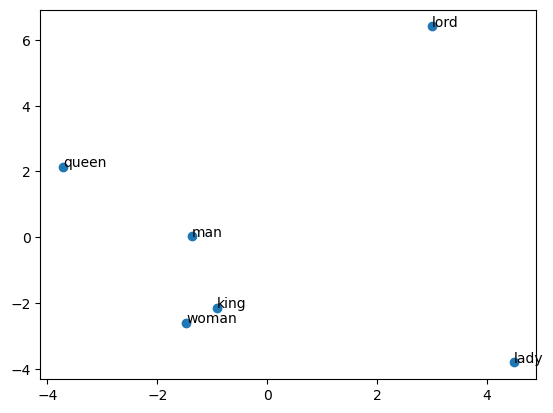

In [38]:
# Plotting the vectors
# In order to plot and visualize the vectors in 2D, we can use an algorithm called *Principal Component Analysis (PCA)* 
# to reduce the vectors' dimensions from 50 (or whichever dimension you chose) down to 2.  This can be easily done using `sklearn`.  


# perform PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings_bef)

# plotting the 2D vectors
plt.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
plt.show()
# plt.savefig("plot.pdf") # save fig to pdf

/opt/anaconda3/envs/english/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

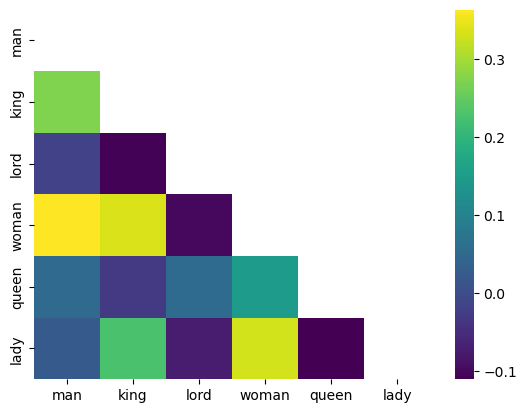

In [39]:
# This code creates a heatmap showing the cosine similarity between each of the words in the list

# compute cosine simil between words
dot_similarity = np.dot(embeddings_bef, embeddings_bef.T)
norms = np.linalg.norm(embeddings_bef, axis=1)
dot_similarity /= np.outer(norms, norms)

# create heatmap (top half has been masked for more clarity, since it shows the same scores as the bottom half)
mask = np.zeros_like(dot_similarity)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dot_similarity,
            xticklabels=words,
            yticklabels=words,
            annot=True,
            mask=mask,
            cmap='viridis')
# plt.savefig("heatmap.pdf") # save fig to pdf

#### **Question** : 

How do you think the cosine similarity scores will/should change after training ?  In the plot, how would you expect the vectors to move ?  Which word vectors should end up closer/farther ?

#### 2.4 Training Loop

Start by selecting the appropriate loss function and optimizer.  You may use `nn.CrossEntropyLoss()` as a loss function and `torch.optim.SGD`for the optimizer.  This optimizer is an implementation of the Gradient Descent algorithm and takes as arguments `model.parameters()`, the model's parameters, and `lr` the learning rate, which can be set to 0.1 when using batches of 128 (experiment with different values here).  

Next you can run the model for 150-200 epochs or until you find little to no change between current_loss and prev_loss.  This should be able to run on your computer, but if not just copy import the notebook into colab.  The fact that we divided the training data into batches means each epoch should take a few secs instead of several minutes.  (Batching is usually used in conjunction with a GPU but can speed things up even on a CPU, which is what we are using here.)

*NOTE: until you reset the parameters by re-instantiating the model, the training loop will continue from where it left off. If you stop and then retstart the cell below, you will continue training the parameters from the last epoch.*

Using device: cpu


In [40]:
import time
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 150

#TRAINING
# around 4s per epoch on my machine (small version)
# you can track the time passed per epoch by decommenting the time1 line and the print(time.time...) at the end.
for epoch in range(epochs):
    time1 = time.time()
    
    # initiliaze the total_loss for each epoch to 0
    total_loss = 0

    # the dataloader is a generator object, it produces a batch of contexts and targets when you iterate over it.
    for context, target in dataloader:
        
        # get the logits
        logits = model(context)
        
        # calculate the loss by passing the logits and targets to the loss_function
        loss = loss_function(logits, target)
        
        # add the loss value to the total_loss (use loss.item() to get the value as a standard number vs a pytorch tensor)
        total_loss += loss.item()

        
        # optimize the network weights using the three steps seen in the XOR notebook
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # track the loss by printing it every 10 epochs (replace with 1 to see the time passed per epoch)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1} : {total_loss}')
    
    print(time.time()-time1)

KeyboardInterrupt: 

In [ ]:
# save your trained model for easier experimentation
torch.save(model.state_dict(), f'cbow_model_{epochs}.pth') # add num of epochs to know which model this is for example

# load your trained model whenever you want with
model = CBOW(vocab_size, embedding_dim=50) # reset the model
model.load_state_dict(torch.load('cbow_model_150.pth')) # load the saved weights

#### 2.5 Visualizing word vectors and similarities after training

Using the same list of words as before, the next cells show the new similarities and plot the new word vectors.  What has changed ? Do the results seem to verify your hypotheses ?  
How do you think the results could be improved ?

Try changing the hyperparameters to see if they have any impact.  These include :

* number of embedding dimensions (ie. size of the embeddings)
* learning rate
* number of epochs
* batch size (optionally)

Training word vectors requires large amounts of text.  This project is a toy example, so do not be discouraged if differences are small... Try to still look for anything noteworthy.  How would you expect the vectors to move ? 

In [ ]:
embeddings_aft = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

[-0.0064013  4.596994 ]


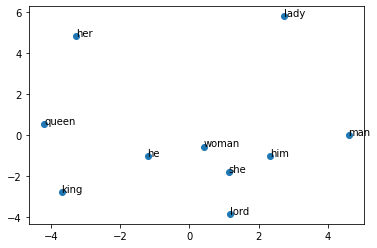

In [45]:
reduced = pca.fit_transform(embeddings_aft)
print(reduced[0])

plt.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
plt.show()
# plt.savefig("plot.pdf") # save fig to pdf

In [ ]:
dot_similarity = np.dot(embeddings_aft, embeddings_aft.T)
norms = np.linalg.norm(embeddings_aft, axis=1)
dot_similarity /= np.outer(norms, norms)

mask = np.zeros_like(dot_similarity)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dot_similarity,
            xticklabels=words,
            yticklabels=words,
            annot=True,
            mask=mask,
            cmap='viridis')
# plt.savefig("heatmap.pdf") # save fig to pdf